In [1]:
import bagpy
from bagpy import bagreader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from scipy.spatial.transform import Rotation
import ipympl

%matplotlib widget


In [2]:
sns.set_theme()
# LaTex must be installed for this to work
# sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

plt.rcParams['text.usetex'] = True
plt.rc('text.latex', preamble=r'\usepackage{bm}')

def drop_columns_in_df(df):
    return df.drop(columns=["header.seq", "header.stamp.secs", "header.stamp.nsecs", "header.frame_id"])

def rename_columns(df, new_colum_names: list):
    column_names = ['Time'] + new_colum_names
    
    df.columns= column_names

    return df

def normalize_df_time(df):
    start_time = df['Time'].iloc[0]

    df['Time'] -= start_time

    return df

def sync_dfs_based_on_time(dataframes: list):
    df_merged = reduce(lambda left,right: pd.merge_asof(left, right, on="Time", allow_exact_matches=True, direction="nearest", tolerance=0.1), dataframes)

    return df_merged

def df_from_pose_to_euler(df):
    quat_df = df[['pose.orientation.x', 'pose.orientation.y', 'pose.orientation.z', 'pose.orientation.w']]
    rot = Rotation.from_quat(quat_df)
    rot_euler = rot.as_euler('xyz', degrees=True)
    euler_df = pd.DataFrame(data=rot_euler, columns=['roll', 'pitch', 'yaw'])

    conc = [df, euler_df]

    df_gt_euler = pd.concat(
        conc,
        axis=1,
        join="outer",
        ignore_index=False,
        keys=None,
        levels=None,
        names=None,
        verify_integrity=False,
        copy=True,
    )

    df_gt_euler = drop_columns_in_df(df_gt_euler)
    df_gt_euler.drop(columns=["pose.position.x", "pose.position.y", "pose.position.z", "pose.orientation.x", "pose.orientation.y","pose.orientation.z","pose.orientation.w"], inplace=True)

    return df_gt_euler

In [3]:
b = bagreader('/home/msccomputer/Desktop/2022-11-22-16-12-59.bag')

b.topic_table

[INFO]  Successfully created the data folder /home/msccomputer/Desktop/2022-11-22-16-12-59.


,Topics,Types,Message Count,Frequency
0,/anafi/attitude,geometry_msgs/QuaternionStamped,4161,34.633615
1,/anafi/gnss_location,sensor_msgs/NavSatFix,4161,34.762498
2,/anafi/gnss_ned_in_body_frame,geometry_msgs/PointStamped,4157,1802.064017
3,/anafi/gnss_ned_in_body_frame/1hz,geometry_msgs/PointStamped,131,0.961885
4,/anafi/height,olympe_bridge/Float32Stamped,4161,34.373061
5,/anafi/image,sensor_msgs/Image,4146,32.589268
6,/anafi/image_t,sensor_msgs/Image,1439,10.984368
7,/anafi/link_goodput,std_msgs/UInt16,4159,34.158491
8,/anafi/link_quality,std_msgs/UInt8,4159,34.091856
9,/anafi/ned_pose_from_gnss,geometry_msgs/PointStamped,4161,34.674989


In [4]:
apriltag_pose = b.message_by_topic('/estimate/aprilTags/pose')
df_apriltag_pose = pd.read_csv(apriltag_pose)

df_apriltag_pose

df_apriltag_pose = drop_columns_in_df(df_apriltag_pose)

df_apriltag_pose = df_apriltag_pose[["Time", "x", "y", "z"]]

df_apriltag_pose = rename_columns(df_apriltag_pose, ["apriltag_x", "apriltag_y", "apriltag_z"])

df_apriltag_pose

,Time,apriltag_x,apriltag_y,apriltag_z
0,1.669130e+09,0.066357,0.065360,0.111900
1,1.669130e+09,0.083353,0.089346,0.179375
2,1.669130e+09,0.086544,0.091061,0.237531
3,1.669130e+09,0.087572,0.081403,0.302075
4,1.669130e+09,0.087201,0.071295,0.366631
...,...,...,...,...
336,1.669130e+09,0.129901,0.088530,0.313615
337,1.669130e+09,0.129564,0.091829,0.292236
338,1.669130e+09,0.130306,0.095197,0.258622
339,1.669130e+09,0.129629,0.098590,0.224145


In [5]:
dnn_pose = b.message_by_topic('/estimate/dnn_cv/position')
df_dnn_pose = pd.read_csv(dnn_pose)

df_dnn_pose = drop_columns_in_df(df_dnn_pose)

df_dnn_pose = rename_columns(df_dnn_pose, ["dnn_x", "dnn_y", "dnn_z"])

In [6]:
ekf_pose = b.message_by_topic('/estimate/ekf')
df_ekf_pose = pd.read_csv(ekf_pose)

df_ekf_pose = drop_columns_in_df(df_ekf_pose)

df_ekf_pose = rename_columns(df_ekf_pose, ["ekf_x", "ekf_y", "ekf_z"] + list(df_ekf_pose.columns[4:]))


In [7]:
gnss_position = b.message_by_topic('/anafi/gnss_ned_in_body_frame/1hz')
df_gnss_position = pd.read_csv(gnss_position)

df_gnss_position = drop_columns_in_df(df_gnss_position)

df_gnss_position = rename_columns(df_gnss_position, ["gnss_x", "gnss_y", "gnss_z"])


In [8]:
anafi_height = b.message_by_topic('/anafi/height')
df_anafi_height = pd.read_csv(anafi_height)

df_anafi_height = drop_columns_in_df(df_anafi_height)

df_anafi_height = rename_columns(df_anafi_height, ["anafi_z"])

In [9]:
#NAN HANDLING AND NP ARRAY GENERATION

def Mask_Or_Drop_Successive_Identical_Values(df, drop=False, 
                                             keep_first=True,
                                             axis=0):

    '''
    Input:
    df should be a pandas.DataFrame of a a pandas.Series
    Output:
    df of ts with masked or dropped values
    '''
    
    # Mask keeping the first occurrence
    if keep_first:
        df = df.mask(df.shift(1) == df)
    # Mask including the first occurrence
    else:
        df = df.mask((df.shift(1) == df) | (df.shift(-1) == df))

    # Drop the values (e.g. rows are deleted)    
    if drop:
        return df.dropna(axis=axis)        
    # Only mask the values (e.g. become 'NaN')
    else:
        return df

def get_np_arr_without_nan(df, datacols_list, remove_identicals=True):
    if remove_identicals:
      df_with_NAN = Mask_Or_Drop_Successive_Identical_Values(df)
    else:
      df_with_NAN = df

    column_names = ['Time'] + datacols_list

    selected_rows = df_with_NAN[~df_with_NAN[datacols_list[0]].isnull()]
    reduced_df_without_NAN = selected_rows[column_names]

    return reduced_df_without_NAN.to_numpy()

In [10]:
df_merged_position = sync_dfs_based_on_time([df_ekf_pose, df_gnss_position, df_apriltag_pose, df_dnn_pose, df_anafi_height])

df_merged_position = normalize_df_time(df_merged_position)

# df_merged_position = df_merged_position.iloc[-970:]

apriltag_data = get_np_arr_without_nan(df_merged_position, ["apriltag_x", "apriltag_y", "apriltag_z"])
dnn_data = get_np_arr_without_nan(df_merged_position, ["dnn_x", "dnn_y", "dnn_z"])
gnss_data = get_np_arr_without_nan(df_merged_position, ["gnss_x", "gnss_y", "gnss_z"])
ekf_data = get_np_arr_without_nan(df_merged_position, ["ekf_x", "ekf_y", "ekf_z", "covariance_0", "covariance_4", "covariance_8"])


In [11]:
df_merged_position.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3478 entries, 0 to 3477
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Time          3478 non-null   float64
 1   ekf_x         3478 non-null   float64
 2   ekf_y         3478 non-null   float64
 3   ekf_z         3478 non-null   float64
 4   covariance_0  3478 non-null   float64
 5   covariance_1  3478 non-null   float64
 6   covariance_2  3478 non-null   float64
 7   covariance_3  3478 non-null   float64
 8   covariance_4  3478 non-null   float64
 9   covariance_5  3478 non-null   float64
 10  covariance_6  3478 non-null   float64
 11  covariance_7  3478 non-null   float64
 12  covariance_8  3478 non-null   float64
 13  gnss_x        654 non-null    float64
 14  gnss_y        654 non-null    float64
 15  gnss_z        654 non-null    float64
 16  apriltag_x    796 non-null    float64
 17  apriltag_y    796 non-null    float64
 18  apriltag_z    796 non-null  

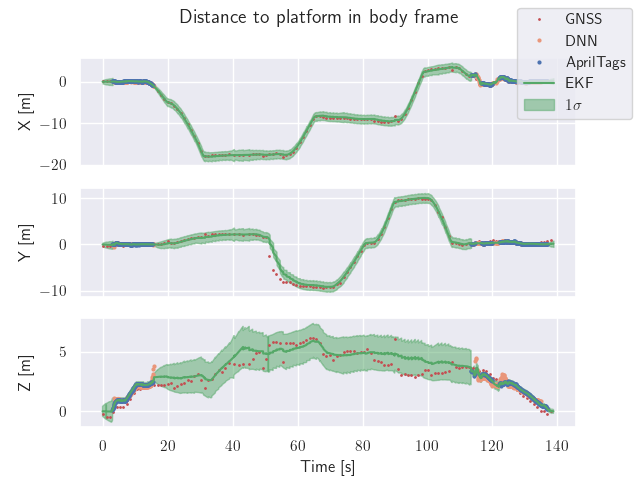

In [14]:
fig, axs = plt.subplots(3, 1)

axs[0].plot(gnss_data[:,0], gnss_data[:,1],'o', ms=1, c='r')
axs[0].plot(dnn_data[:,0], dnn_data[:,1], 'o', ms=2, c='darksalmon')
axs[0].plot(apriltag_data[:,0], apriltag_data[:,1], 'o', ms=2, c='b')
axs[0].plot(ekf_data[:,0], ekf_data[:,1], c='g')
axs[0].fill_between(ekf_data[:,0], 
                    y1=ekf_data[:,1] - np.sqrt(ekf_data[:,4]), 
                    y2=ekf_data[:,1] + np.sqrt(ekf_data[:,4]), 
                    alpha=.5, color='g')
axs[0].set_ylabel('X [m]')
axs[0].grid(True)
axs[0].set_xticklabels([])


axs[1].plot(gnss_data[:,0], gnss_data[:,2],'o', ms=1, c='r')
axs[1].plot(dnn_data[:,0], dnn_data[:,2], 'o', ms=2, c='darksalmon')
axs[1].plot(apriltag_data[:,0], apriltag_data[:,2], 'o', ms=2, c='b')
axs[1].plot(ekf_data[:,0], ekf_data[:,2], c='g')
axs[1].fill_between(ekf_data[:,0], 
                    y1=ekf_data[:,2] - np.sqrt(ekf_data[:,5]), 
                    y2=ekf_data[:,2] + np.sqrt(ekf_data[:,5]), 
                    alpha=.5, color='g')
axs[1].set_xticklabels([])
axs[1].set_ylabel('Y [m]')
axs[1].grid(True)
axs[1].set_xticklabels([])





axs[2].plot(gnss_data[:,0], gnss_data[:,3],'o', ms=1, c='r')
axs[2].plot(dnn_data[:,0], dnn_data[:,3], 'o', ms=2, c='darksalmon')
axs[2].plot(apriltag_data[:,0], apriltag_data[:,3], 'o', ms=2, c='b')
axs[2].plot(ekf_data[:,0], ekf_data[:,3], c='g')
axs[2].fill_between(ekf_data[:,0], 
                    y1=ekf_data[:,3] - np.sqrt(ekf_data[:,6]), 
                    y2=ekf_data[:,3] + np.sqrt(ekf_data[:,6]), 
                    alpha=.5, color='g')
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Z [m]')
axs[2].grid(True)

handles, labels = axs[2].get_legend_handles_labels()
labels = ["GNSS", "DNN", "AprilTags", "EKF", r"$1\sigma$"]
fig.legend(labels, loc='upper right', ncol=1)
fig.suptitle('Distance to platform in body frame', fontsize=14)
fig.align_ylabels(axs)

plt.show()
plt.savefig("figures_outside/full_z_cov_reduced.svg")

# WITHOUT GNSS 

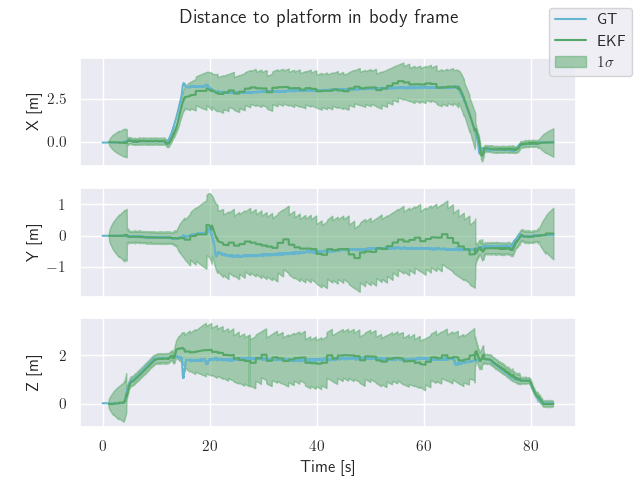

In [29]:
fig, axs = plt.subplots(3, 1)

axs[0].plot(ekf_data[:,0], ekf_data[:,1], c='g')
axs[0].fill_between(ekf_data[:,0], 
                    y1=ekf_data[:,1] - np.sqrt(ekf_data[:,4]), 
                    y2=ekf_data[:,1] + np.sqrt(ekf_data[:,4]), 
                    alpha=.5, color='g')
axs[0].set_ylabel('X [m]')
axs[0].grid(True)
axs[0].set_xticklabels([])

axs[1].plot(ekf_data[:,0], ekf_data[:,2], c='g')
axs[1].fill_between(ekf_data[:,0], 
                    y1=ekf_data[:,2] - np.sqrt(ekf_data[:,5]), 
                    y2=ekf_data[:,2] + np.sqrt(ekf_data[:,5]), 
                    alpha=.5, color='g')
axs[1].set_xticklabels([])
axs[1].set_ylabel('Y [m]')
axs[1].grid(True)
axs[1].set_xticklabels([])




axs[2].plot(ekf_data[:,0], ekf_data[:,3], c='g')
axs[2].fill_between(ekf_data[:,0], 
                    y1=ekf_data[:,3] - np.sqrt(ekf_data[:,6]), 
                    y2=ekf_data[:,3] + np.sqrt(ekf_data[:,6]), 
                    alpha=.5, color='g')
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Z [m]')
axs[2].grid(True)

handles, labels = axs[2].get_legend_handles_labels()
labels = ["GT", "EKF", r"$1\sigma$"]
fig.legend(labels, loc='upper right', ncol=1)
fig.suptitle('Distance to platform in body frame', fontsize=14)
fig.align_ylabels(axs)

plt.show()

In [76]:
df_merged_position = sync_dfs_based_on_time([df_ekf_pose, df_apriltag_pose, df_dnn_pose, df_anafi_height])

df_merged_position = normalize_df_time(df_merged_position)

# df_merged_position = df_merged_position.iloc[-970:]

apriltag_data = get_np_arr_without_nan(df_merged_position, ["apriltag_x", "apriltag_y", "apriltag_z"])
dnn_data = get_np_arr_without_nan(df_merged_position, ["dnn_x", "dnn_y", "dnn_z"])
ekf_data = get_np_arr_without_nan(df_merged_position, ["ekf_x", "ekf_y", "ekf_z", "covariance_0", "covariance_4", "covariance_8"])

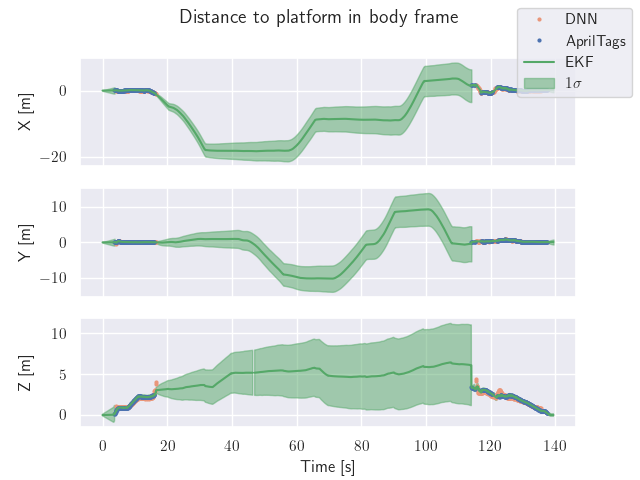

In [79]:
fig, axs = plt.subplots(3, 1)

axs[0].plot(dnn_data[:,0], dnn_data[:,1], 'o', ms=2, c='darksalmon')
axs[0].plot(apriltag_data[:,0], apriltag_data[:,1], 'o', ms=2, c='b')
axs[0].plot(ekf_data[:,0], ekf_data[:,1], c='g')
axs[0].fill_between(ekf_data[:,0], 
                    y1=ekf_data[:,1] - np.sqrt(ekf_data[:,4]), 
                    y2=ekf_data[:,1] + np.sqrt(ekf_data[:,4]), 
                    alpha=.5, color='g')
axs[0].set_ylabel('X [m]')
axs[0].grid(True)
axs[0].set_xticklabels([])


axs[1].plot(dnn_data[:,0], dnn_data[:,2], 'o', ms=2, c='darksalmon')
axs[1].plot(apriltag_data[:,0], apriltag_data[:,2], 'o', ms=2, c='b')
axs[1].plot(ekf_data[:,0], ekf_data[:,2], c='g')
axs[1].fill_between(ekf_data[:,0], 
                    y1=ekf_data[:,2] - np.sqrt(ekf_data[:,5]), 
                    y2=ekf_data[:,2] + np.sqrt(ekf_data[:,5]), 
                    alpha=.5, color='g')
axs[1].set_xticklabels([])
axs[1].set_ylabel('Y [m]')
axs[1].grid(True)
axs[1].set_xticklabels([])





axs[2].plot(dnn_data[:,0], dnn_data[:,3], 'o', ms=2, c='darksalmon')
axs[2].plot(apriltag_data[:,0], apriltag_data[:,3], 'o', ms=2, c='b')
axs[2].plot(ekf_data[:,0], ekf_data[:,3], c='g')
axs[2].fill_between(ekf_data[:,0], 
                    y1=ekf_data[:,3] - np.sqrt(ekf_data[:,6]), 
                    y2=ekf_data[:,3] + np.sqrt(ekf_data[:,6]), 
                    alpha=.5, color='g')
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Z [m]')
axs[2].grid(True)

handles, labels = axs[2].get_legend_handles_labels()
labels = ["DNN", "AprilTags", "EKF", r"$1\sigma$"]
fig.legend(labels, loc='upper right', ncol=1)
fig.suptitle('Distance to platform in body frame', fontsize=14)
fig.align_ylabels(axs)

plt.show()
plt.savefig("figures_outside/full_no_gnss.svg")